# What reading grade level is required for each Trump tweet?

Some prep: 
```
pip install pandas
pip install textstat
```

#### Future work: 
Tutorial on the [Naive Bayes Classifier in NLTK](https://www.twilio.com/blog/2017/09/sentiment-analysis-python-messy-data-nltk.html)

[Sentiment analysis database](https://github.com/vineetdhanawat/twitter-sentiment-analysis)

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from textstat.textstat import textstat
import numpy as np

from datetime import datetime
import json

In [34]:
import time

def decimal_year(timestamp):
    
    date = datetime.fromtimestamp(timestamp)
    
    def since_epoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())

    year = date.year
    start_of_this_year = datetime(year=year, month=1, day=1)
    start_of_next_year = datetime(year=year+1, month=1, day=1)

    year_elapsed = since_epoch(date) - since_epoch(start_of_this_year)
    year_duration = since_epoch(start_of_next_year) - since_epoch(start_of_this_year)
    fraction = year_elapsed / year_duration

    return date.year + fraction

def grade_level(tweet):
    grade_level_metrics = [
        textstat.flesch_kincaid_grade(tweet),
        textstat.coleman_liau_index(tweet),
        textstat.automated_readability_index(tweet),
        textstat.linsear_write_formula(tweet),
        textstat.gunning_fog(tweet)
    ]
    return np.median(grade_level_metrics)

s = """I had to fire General Flynn because he lied to the Vice President 
and the FBI. He has pled guilty to those lies. It is a shame because 
his actions during the transition were lawful. There was nothing to 
hide!"""

print('Median grade level: {0}'.format(grade_level(s)))

Median grade level: 3.8


In [35]:
tweets = json.loads(open('cleaned_tweets.json').read())

In [36]:
year = []
grade = []

for i, timestamp in enumerate(tweets):
    if len(tweets[timestamp]) > 1:
        year.append(decimal_year(timestamp))
        grade.append(grade_level(tweets[timestamp]))

In [37]:
year = np.array(year)
grade = np.array(grade)

In [38]:
df = pd.DataFrame(data=np.vstack([year, grade]).T, columns=['year', 'grade'])
df.set_index('year');

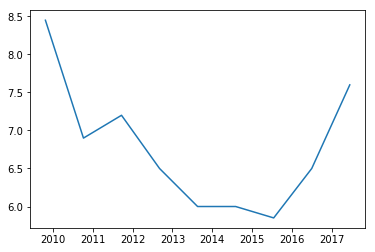

In [39]:
from scipy.stats import binned_statistic

bs = binned_statistic(year, grade, bins=np.linspace(min(year), max(year), 10), 
                      statistic='median')
bin_centers = 0.5 * (bs.bin_edges[1:] + bs.bin_edges[:-1])
medians = bs.statistic

plt.plot(bin_centers, medians)

In [40]:
histograms = []

year_bins = np.arange(int(min(year)), int(max(year))+1, 0.5)
year_bin_centers = 0.5*(year_bins[1:] + year_bins[:-1])
grade_bins = np.arange(0, 21)
tweet_count = []

for i in range(len(year_bins) - 1):
    within_bin = ((year < year_bins[i+1]) & 
                  (year > year_bins[i]))
    tweet_count.append(np.count_nonzero(within_bin))
    hist = np.histogram(grade[within_bin], bins=grade_bins, normed=True)[0]
    
    histograms.append(hist)
histograms = np.array(histograms).T

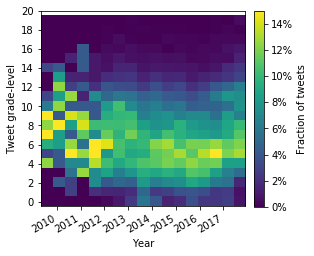

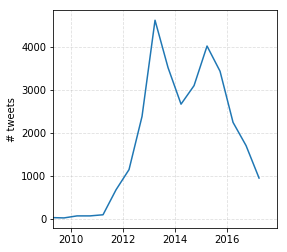

In [41]:
from matplotlib import ticker
from matplotlib import gridspec

half_year_bin = 0.5*(year_bins[1] - year_bins[0])
extent = [min(year), max(year), 
          min(grade_bins)-0.5, max(grade_bins)-0.5]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

im = ax.imshow(histograms, origin='lower', vmin=0, vmax=0.15, 
                  extent=extent, aspect=0.4)
ax.set_xticks(np.arange(2010, 2018))
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_yticks(grade_bins[::2])
ax.set_ylabel('Tweet grade-level')
ax.set_xlabel('Year')
fig.savefig('plots/tweet_grade_level.png', dpi=200, bbox_inches='tight')

cbar = plt.colorbar(im, fraction=0.044, pad=0.04)

cbar.set_ticks(np.array(cbar.get_ticks()).astype(float))
cbar.set_ticklabels(list(map("{0:.0f}%".format, 
                             np.array(cbar.get_ticks()).astype(float) * 100)))
cbar.set_label('Fraction of tweets')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(year_bin_centers, tweet_count)
ax.set_ylabel('# tweets')

ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
ax.set_xlim([min(year), max(year)])
ax.grid(ls='--', alpha=0.4)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=None, hspace=0.05)

plt.show()

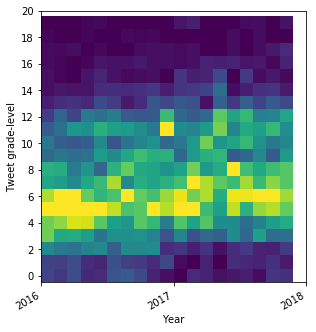

In [42]:
year_bins = np.arange(2016, 2018, 0.1)
grade_bins = np.arange(0, 21)

histograms = []
for i in range(len(year_bins) - 1):
    within_bin = ((year < year_bins[i+1]) & 
                  (year > year_bins[i]))
    hist = np.histogram(grade[within_bin], bins=grade_bins, normed=True)[0]
    
    histograms.append(hist)
histograms = np.array(histograms).T

half_year_bin = 0.5*(year_bins[1] - year_bins[0])
extent = [min(year_bins), max(year_bins), 
          min(grade_bins)-0.5, max(grade_bins)-0.5]

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(histograms, origin='lower', vmin=0, vmax=0.14, 
          extent=extent, aspect=0.1)
ax.set_xticks(np.arange(min(year_bins), max(year_bins)+1))
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_yticks(grade_bins[::2])
ax.set_ylabel('Tweet grade-level')
ax.set_xlabel('Year');

# We all know...

that Trump watches Fox and Friends. Let's see if his vocabulary changes when watching his favorite entertainment.

In [43]:
timestamps = [k for k in tweets]

In [84]:
import pytz

native_timezone = pytz.timezone('GMT')
trump_timezone = pytz.timezone('US/Eastern')

localize = lambda t: datetime.fromtimestamp(float(t), tz=trump_timezone).replace(tzinfo=None)

localized_dts = [localize(t) for t in timestamps]

In [93]:
during_faf = [(dt.hour <= 9) and (dt.hour >= 6) and dt.weekday() 
              for dt in localized_dts]

In [100]:
tweets_during_faf = {key: tweets[key] for i, key in enumerate(tweets) 
                     if during_faf[i]}
tweets_not_during_faf = {key: tweets[key] for i, key in enumerate(tweets) 
                         if not during_faf[i]}

print('There are {0} tweets during Fox and Friends'.format(len(tweets_during_faf)))

There are 2550 tweets during Fox and Friends


In [99]:
len(tweets_during_faf), len(tweets_not_during_faf)

(2550, 29345)

In [102]:
grade_faf = np.array([grade_level(tweets[timestamp]) 
                      for timestamp in tweets_during_faf])
grade_not_faf = np.array([grade_level(tweets[timestamp]) 
                         for timestamp in tweets_not_during_faf])

In [ ]:
plt.hist(grade_faf)
plt.hist(grade_not_faf)